## Finetune [paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2) using LoRA
In this notebook, **Contrastive Learning** is used to finetune the `paraphrase-mpnet-base-v2` model. Specifically, for every query, one relevant chunk is used as a positive example and the irrelevant chunk that appeared on the top of retrieval is used as a negative example.<br>
Loss function used: [`CoSENTLoss`](https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#cosentloss)<br><br>
Here is the expression for the loss function:
$$
\text{loss} = \text{logsum}(1 + \exp(s(k, l) - s(i, j)) + ...)
$$
where $(i,j)$ and $(k,l)$ are any of the input pairs in the batch such that the expected similarity of $(i,j)$ is greater than $(k,l)$. The summation is over all possible pairs of input pairs in the batch that match this condition.

In [3]:
from transformers import AutoModel, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
torch.manual_seed(0)
np.random.seed(0)

/export/home/co21btech11001/.conda/envs/nlp_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load model

In [5]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [6]:
model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

## Configure LoRA using [peft](https://huggingface.co/docs/peft/en/index) library

In [ ]:
config = LoraConfig(
    r = 8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="FEATURE_EXTRACTION",
    target_modules=["q", "v", "k", "o"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 589,824 || all params: 110,076,288 || trainable%: 0.5358


In [8]:
batch_size = 16

args = TrainingArguments(
    output_dir="train_output",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=8,
    logging_dir="train_logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

## Load data

In [9]:
df_ques_url_train = pd.read_pickle('../../data/ques_rel_url_hard_negs_train.pkl')
print(df_ques_url_train.shape)
df_ques_url_train.head()

(20000, 4)


,question,relevant_docs_urls,num_rel_chunks,hard_negatives_li
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...,5,[https://www.nlm.nih.gov/medlineplus/ency/arti...
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5,[https://www.nlm.nih.gov/medlineplus/ency/arti...
2,What are the genetic changes related to kerato...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5,[https://ghr.nlm.nih.gov/condition/monilethrix...
3,Is keratoderma with woolly hair inherited ?,[https://ghr.nlm.nih.gov/condition/keratoderma...,5,[https://www.nlm.nih.gov/medlineplus/ency/arti...
4,What are the treatments for keratoderma with w...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5,[https://www.nlm.nih.gov/medlineplus/ency/arti...


In [10]:
# Check if length of 'hard_negatives_li' column is not zero
df_ques_url_train['hard_negatives_li'].apply(lambda x: len(x)).value_counts()

hard_negatives_li
33541    8028
33542    4436
33540    3735
33539    1618
33543     631
33538     546
33537     200
33536     149
33531     130
33535     115
33533     105
33530      90
33534      85
33532      59
33529      45
33528      13
33524       4
33514       2
33525       2
33526       2
33518       2
33521       1
33523       1
33516       1
Name: count, dtype: int64

In [11]:
df_kb = pd.read_pickle('../../data/kb_chunks_emb.pkl')
print(df_kb.shape)
df_kb.head(3)

(33545, 3)


,doc_url,chunk_content,embedding
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,keratoderma with woolly hair : medlineplus gen...,"[-0.0039987266, 0.08037464, 0.049785912, -0.12..."
1,https://ghr.nlm.nih.gov/condition/keratoderma-...,"##ma, woolly hair, and a form of cardiomyopath...","[-0.09539697, -0.09132044, 0.0027289127, 0.005..."
2,https://ghr.nlm.nih.gov/condition/keratoderma-...,##pathy in people with this group of condition...,"[0.026278932, 0.060939535, 0.031438153, -0.044..."


In [12]:
def create_pairs(df_ques_url, df_kb, train_size):
    """
    For every question, choose a random relevant document and a random chunk from that document.
    """
    pos_pairs = []
    neg_pairs = []

    for i in range(train_size):
        query = df_ques_url['question'][i]
        rel_docs = df_ques_url['relevant_docs_urls'][i]
        # Choose a random relevant doc
        rel_doc = np.random.choice(rel_docs)
        # Choose the first negative doc
        neg_doc = df_ques_url['hard_negatives_li'][i][0]
        # Choose a chunk from the relevant doc
        rel_doc_chunk = df_kb[df_kb['doc_url'] == rel_doc]['chunk_content'].values[0]
        # Choose a chunk from the negative doc
        neg_doc_chunk = df_kb[df_kb['doc_url'] == neg_doc]['chunk_content'].values[0]
        pos_pairs.append((query, rel_doc_chunk))
        neg_pairs.append((query, neg_doc_chunk))

    return pos_pairs, neg_pairs

TRAIN_SIZE = 12_000
train_pos_pairs, train_neg_pairs = create_pairs(df_ques_url_train, df_kb, TRAIN_SIZE)

In [13]:
from torch.utils.data import Dataset
import torch.nn.functional as F

class BioDataset(Dataset):
    def __init__(self, pos_pairs, neg_pairs, tokenizer):
        self.pairs = pos_pairs + neg_pairs
        self.labels = [1.0] * len(pos_pairs) + [-1.0] * len(neg_pairs)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        query, doc = self.pairs[idx]
        inputs = self.tokenizer([query, doc], padding="max_length", truncation=True, return_tensors="pt")
        inputs["label"] = self.labels[idx]
        return inputs
    
train_dataset = BioDataset(train_pos_pairs, train_neg_pairs, tokenizer)

In [14]:
print(train_dataset[0]['input_ids'].shape, flush = True)

torch.Size([2, 512])


In [15]:
# Collate function
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'].squeeze() for item in batch])
    attention_mask = torch.stack([item['attention_mask'].squeeze() for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [16]:
BATCH_SIZE = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=True, collate_fn=collate_fn)

In [17]:
batch = next(iter(train_dataloader))
print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape, flush = True)

torch.Size([2, 2, 512]) torch.Size([2, 2, 512]) torch.Size([2])


In [18]:
# Forward pass on the model without gradients
with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"].view(-1, batch["input_ids"].size(-1)),
        attention_mask=batch["attention_mask"].view(-1, batch["attention_mask"].size(-1))
    )

for k, v in outputs.items():
    print(k, v.shape)

last_hidden_state torch.Size([4, 512, 768])
pooler_output torch.Size([4, 768])


## Fine-tune using LoRA

In [19]:
# Transfer model to the device
model.to(device)
print("Model loaded on device", flush=True)

Model loaded on device


In [20]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [21]:
from typing import Any, Dict
from torch import nn, Tensor

class CoSENTLoss(nn.Module):
    def __init__(self, model: AutoModel, mean_pooling_fn, scale: float = 20.0, similarity_fct=nn.CosineSimilarity(dim=-1)) -> None:
        """
        Implements CoSENT (Cosine Sentence) loss using mean pooling.

        Args:
            model: AutoModel instance.
            mean_pooling_fn: Function to perform mean pooling on model outputs.
            scale: Inverse temperature scaling factor.
            similarity_fct: Function to compute pairwise cosine similarity.
        """
        super().__init__()
        self.model = model
        self.mean_pooling = mean_pooling_fn
        self.similarity_fct = similarity_fct
        self.scale = scale

    def forward(self, batch: Dict) -> Tensor:
        input_ids = batch["input_ids"].view(-1, batch["input_ids"].size(-1))
        attention_mask = batch["attention_mask"].view(-1, batch["attention_mask"].size(-1))
        labels = batch["labels"]

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.mean_pooling(outputs, attention_mask)


        scores = self.similarity_fct(embeddings[::2], embeddings[1::2])
        scores = scores * self.scale
        # scores[:, None] converts scores to a column vector
        # scores[None, :] converts scores to a row vector
        # column vector - row vector is a matrix M where M[i, j] = scores[i] - scores[j]
        scores = scores[:, None] - scores[None, :]

        # Label matrix indicating which pairs are relevant
        # labels[:, None] is a column vector
        # labels[None, :] is a row vector
        # column vector - row vector is a matrix M where M[i, j] = labels[i] < labels[j]
        labels = labels[:, None] < labels[None, :]
        labels = labels.float()

        # Mask out irrelevant pairs so they are negligible after exp()
        # When labels[i, j] = 0, scores[i, j] = -inf => exp(-inf) = 0
        scores = scores - (1 - labels) * 1e12

        # Append a zero as e^0 = 1
        scores = torch.cat((torch.zeros(1).to(scores.device), scores.view(-1)), dim=0)
        loss = torch.logsumexp(scores, dim=0)

        return loss

    def get_config_dict(self) -> Dict[str, Any]:
        return {"scale": self.scale, "similarity_fct": self.similarity_fct.__name__}

In [22]:
from torch.optim import AdamW

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=args.learning_rate)
loss_fn = CoSENTLoss(model, mean_pooling)

In [ ]:
# Training loop
losses = []
for epoch in range(args.num_train_epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        optimizer.zero_grad()

        # Move inputs to device
        batch = {k: v.to(device) for k, v in batch.items()}

        loss = loss_fn(batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        if (i % 100 == 0):
            if i > 0:
                avg_loss = total_loss / ((i+1) * batch_size)
            else:
                avg_loss = total_loss
            print("Loss: ", avg_loss, flush=True)
            losses.append(avg_loss)

    # Shuffle the dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                               shuffle=True, collate_fn=collate_fn)    
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}", flush=True)

Epoch 1:   0%|          | 0/12000 [00:00<?, ?it/s]

Loss:  0.0


Epoch 1:   0%|          | 41/12000 [00:16<1:18:54,  2.53it/s]

**Note:** Takes 10 GB of GPU memory for batch size of 8, 20GB for batch size of 16<br>
Takes 18 minutes per epoch

In [ ]:
# Save the model
model_save_path = "mpnet_peft_ft_cosent"
model.save_pretrained(model_save_path)
print(f"Model saved at {model_save_path}", flush=True)

Model saved at mpnet_peft_ft_cosent


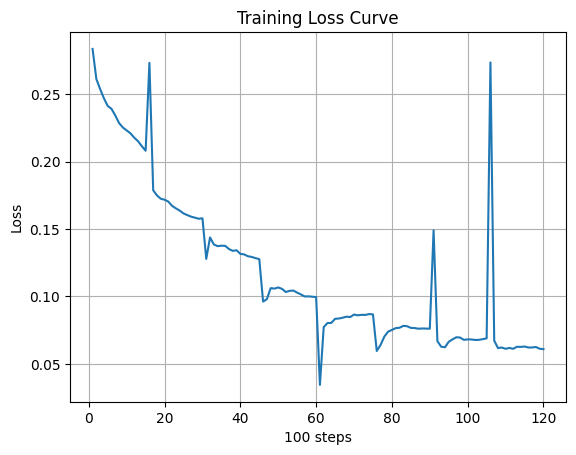

In [ ]:
# Loss curve
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("100 steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()